# Compute and Analyze Classifier Metrics

The snakemake pipeline output the probability of 0 / 1 for each cell for each classifier. Here, we compute and save many common metrics from these probabilities. Here we analyze the classification results of each allele.

In [1]:
# imports
import os
import polars as pl
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from plot_utils import *
letter_dict_rev = {v: k for k, v in letter_dict.items()}
channel_dict_rev = {v: k for k, v in channel_dict.items()}

# letter_dict_rev
channel_list = list(channel_dict_rev.values())[:-3]
channel_list

%matplotlib inline
## Disable truncation globally
# pl.Config.set_tbl_rows(20)  # Show all rows
# pl.Config.set_tbl_cols(40)  # Show all columns

## define control types
TC = ["EGFP"]
NC = ["RHEB", "MAPK9", "PRKACB", "SLIRP"]
PC = ["ALK", "ALK_Arg1275Gln", "PTK2B"]
cNC = ["Renilla"]
cPC = ["KRAS", "PTK2B", "GHSR", "ABL1", "BRD4", "OPRM1", "RB1", "ADA", "WT PMP22", "LYN", "TNF", 
       "CYP2A6", "CSK", "PAK1", "ALDH2", "CHRM3", "KCNQ2", "ALK T1151M", "PRKCE", "LPAR1", "PLP1"]

FEAT_SETS = ["DNA", "Mito", "GFP", "AGP", "Morph"]
PLATEMAP_DIR = "../../../1_inputs/1_snakemake_pipeline/inputs/metadata/platemaps/{batch_id}/platemap"
CLASS_RES_DIR = "../../../3_outputs/1_snakemake_pipeline/2.sm_pipeline_outputs/classification_analyses"
CLASS_RES_OUTDIR = "../../../3_outputs/1_snakemake_pipeline/3.smp_results_analyses"

TRN_IMBAL_THRES = 3
MIN_CLASS_NUM = 2
AUROC_THRESHOLDS = [0.95, 0.99]

In [2]:
BIO_REP_BATCHES = ["2025_01_27_Batch_13", "2025_01_28_Batch_14"]
COMBINED_BIO_REP_DIR = "2025_01_Batch_13-14"

BIO_REP_BATCHES_DICT = {
    # "2024_01_Batch_7-8": ("2024_01_23_Batch_7", "2024_02_06_Batch_8"),
    # "2024_12_Batch_11-12": ("2024_12_09_Batch_11", "2024_12_09_Batch_12"),
    # "2025_03_Batch_15-16": ("2025_03_17_Batch_15", "2025_03_17_Batch_16"),
    "2025_01_Batch_13-14": ("2025_01_27_Batch_13", "2025_01_28_Batch_14")
}

IMG_QC_DIR = f"../../../3_outputs/1_snakemake_pipeline/3.smp_results_analyses/1.image_qc_outputs/{COMBINED_BIO_REP_DIR}"
OUTPUT_DIR = f"../../../3_outputs/1_snakemake_pipeline/3.smp_results_analyses/3.classification_analyses/{COMBINED_BIO_REP_DIR}"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

## 1. Metadata

In [3]:
allele_meta_dict = {}
for batch_id in BIO_REP_BATCHES:
    allele_meta_df = pl.DataFrame()
    for platemap in os.listdir(PLATEMAP_DIR.format(batch_id=batch_id)):
        platemap_df = pl.read_csv(os.path.join(PLATEMAP_DIR.format(batch_id=batch_id), platemap), separator="\t", infer_schema_length=100000)
        allele_meta_df = pl.concat([allele_meta_df, 
                                    platemap_df.filter((pl.col("node_type").is_not_null()))], # (~pl.col("node_type").is_in(["TC","NC","PC"]))&
                                    how="diagonal_relaxed").sort("plate_map_name")
        allele_meta_df = allele_meta_df.with_columns(pl.col("plate_map_name").str.split('_').list.get(0).alias("plate_map"))
    allele_meta_dict[batch_id] = allele_meta_df

In [4]:
img_well_qc_sum = pl.read_csv(f"{IMG_QC_DIR}/plate-well-level_img_qc_sum.csv")
img_well_qc_sum = img_well_qc_sum.with_columns(
    pl.col("channel").replace("DAPI", "DNA").alias("channel")
)
img_well_qc_sum_morph = img_well_qc_sum.filter(pl.col("channel")!="GFP")
img_well_qc_sum_morph = img_well_qc_sum_morph.group_by(["plate","well"]).agg(
    pl.col("is_bg").max().alias("is_bg"),
    pl.col("s2n_ratio").mean().alias("s2n_ratio")
).with_columns(pl.lit("Morph").alias("channel"))
img_well_qc_sum = pl.concat([
    img_well_qc_sum.select(pl.col(["plate","well","channel","is_bg","s2n_ratio"])),
    img_well_qc_sum_morph.select(pl.col(["plate","well","channel","is_bg","s2n_ratio"])),
], how="vertical_relaxed")

# img_well_qc_sum["channel"].unique()
# img_well_qc_sum_gfp = img_well_qc_sum.filter(pl.col("channel")=="GFP").with_columns(
#     pl.col("plate").alias("Metadata_Plate"),
#     pl.col("well").alias("Metadata_Well"),
# )

In [5]:
class_info_dir = "{}/{}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells/metrics.csv"

for batch_id in BIO_REP_BATCHES:
    class_res_df = pl.read_csv(class_info_dir.format(CLASS_RES_DIR, batch_id))
    class_res_df = class_res_df.with_columns(
        pl.when((pl.col("well_0").str.contains(r"(?:01|P|A|24)"))|(pl.col("well_1").str.contains(r"(?:01|P|A|24)")))
        .then(pl.lit(True))
        .otherwise(pl.lit(False))
        .alias("Well_On_Edge")
    )
    # display(class_res_df)
    for channel in channel_list:
        class_res_df_channel = class_res_df.filter(pl.col("Metadata_Feature_Type")==channel)
        class_res_df_channel = class_res_df_channel.join(
            img_well_qc_sum.filter(pl.col("channel")==channel).select(pl.col(["plate","well","is_bg"])),
            left_on=["Plate","well_0"],
            right_on=["plate","well"]
        ).rename({"is_bg": "well_0_is_bg"})
        class_res_df_channel = class_res_df_channel.join(
            img_well_qc_sum.filter(pl.col("channel")==channel).select(pl.col(["plate","well","is_bg"])),
            left_on=["Plate","well_1"],
            right_on=["plate","well"]
        ).rename({"is_bg": "well_1_is_bg"})
        
        plate_maps = sorted(set(["_".join(pm.split("_")[:-1]) for pm in class_res_df_channel["Plate"].unique()]))
        for pm in plate_maps:
            class_res_ch_pm = class_res_df_channel.filter(pl.col("Plate").str.contains(pm))
            plates = sorted(class_res_ch_pm["Plate"].unique().to_list())
            
            # fig, axes = plt.subplots(2,2,figsize=(48,23)) ## sharey=True,sharex=True
            for plate in plates:
                plate_info = class_res_ch_pm.filter(pl.col("Plate")==plate)

                ## plot the ctrls alleles first
                plate_info_ctrl = plate_info.filter(pl.col("Metadata_Control"))
                ctrls_wells = pl.concat([plate_info_ctrl["well_0"], plate_info_ctrl["well_1"]]).unique()
                agg_group_by_well_0 = plate_info_ctrl.group_by("well_0","allele_0").agg([
                    pl.col("AUROC").mean().alias("AUROC_Mean"),
                    pl.col("well_0_is_bg").max().alias("is_bg")
                ]).rename(
                    {"well_0": "well", "allele_0": "allele"}
                )#.with_columns(pl.col("Well_On_Edge").cast(pl.Boolean).alias("Well_On_Edge"))
                agg_group_by_well_1 = plate_info_ctrl.filter(
                    (pl.col("well_1").is_in(ctrls_wells))&\
                    (~pl.col("well_1").is_in(agg_group_by_well_0["well"]))
                ).group_by("well_1","allele_1").agg([
                    pl.col("AUROC").mean().alias("AUROC_Mean"),
                    pl.col("well_1_is_bg").max().alias("is_bg")
                ]).rename(
                    {"well_1": "well", "allele_1": "allele"}
                )
                agg_group_by_well = pl.concat(
                    [
                        agg_group_by_well_0.select(pl.col("well","AUROC_Mean","allele","is_bg")),
                        agg_group_by_well_1.select(pl.col("well","AUROC_Mean","allele","is_bg"))
                    ]
                )
                ## plot the auroc per each plate for a platemap
            #     plot_platemap(
            #         agg_group_by_well,
            #         plate+f"_{channel}",
            #         well_pos_col="well",
            #         # this is the column to color by (categorical or continuous)
            #         value_col="AUROC_Mean",
            #         # these columns will be concatenated into the annotation text
            #         label_cols=("allele","AUROC_Mean"),
            #         ax=axes[plates.index(plate)//2, plates.index(plate)%2],
            #         value_type="continuous",   # or "continuous"
            #         continuous_cmap="vlag",  # matplotlib colormap for continuous mode
            #         categorical_colors={True: "tomato", False: "skyblue"},     # dict for categorical → color
            #         grid_square="is_bg"
            #     )
            # fig.subplots_adjust(wspace=-.55, hspace=.05)
            # plt.tight_layout()

## 2. Classification metrics

### 2.1 Analyze the metrics per each classifier:

Each tested allele should have 2 (protein mislocalization & morphology) * 4 (technical replicates) = 8 classifiers per each batch.

In [6]:
metric_df_dict = {}

for batch_id in BIO_REP_BATCHES:
    metrics_df = pl.read_csv(class_info_dir.format(CLASS_RES_DIR, batch_id))
    batch_id = f"B{batch_id.split('Batch_')[-1]}"
    # display(metrics_df)

    print(f"====================================={batch_id} metrics=====================================")
    metrics_df = metrics_df.with_columns(
        pl.when(pl.col("Metadata_Control"))
        .then(pl.lit("1_Ctrl"))
        .otherwise(pl.lit("2_VAR-WT"))
        .alias("Node_Type"),
        pl.col("Metadata_Feature_Type").alias("Classifier_type"),
        # Extract the substring that:
        #  1. Has a digit (\d) immediately before it (anchors the match at a number)
        #  2. Starts with 'A' and then as few characters as needed (A.*?), captured as group 1
        #  3. Stops right before the literal 'T'
        pl.col("Plate").str.extract(r"\d(A.*?)T", 1).alias("Allele_set"),
        pl.col("Full_Classifier_ID").str.split("_").list.last().alias("Batch")
    )
    # display(metrics_df)

    metrics_df = metrics_df.join(
        img_well_qc_sum.select(pl.col("plate", "well", "channel", "is_bg")),
        left_on=["Plate", "well_0", "Metadata_Feature_Type"],
        right_on=["plate", "well", "channel"]
    ).rename({"is_bg": "well_0_is_bg"})
    metrics_df = metrics_df.join(
        img_well_qc_sum.select(pl.col("plate", "well", "channel", "is_bg")),
        left_on=["Plate", "well_1", "Metadata_Feature_Type"],
        right_on=["plate", "well", "channel"]
    ).rename({"is_bg": "well_1_is_bg"})

    """
        Calculating controls
    """
    metrics_ctrl_df = metrics_df.filter(
        (~pl.col("well_0_is_bg")) & (~pl.col("well_1_is_bg")) & \
        (pl.col("Training_imbalance") < TRN_IMBAL_THRES) & (pl.col("Metadata_Control"))
    )    
    # Filter based on class imbalance
    metrics_ctrl = (
        metrics_ctrl_df
        .select(["Classifier_type", "Batch", "AUROC"])
        .group_by(["Classifier_type", "Batch"])
        .agg([
            pl.col("AUROC").mean().alias("AUROC_mean"),
            pl.col("AUROC").std().alias("AUROC_std")
        ]+[
            pl.col("AUROC").quantile(auroc_thres).alias(f"AUROC_thresh_{auroc_thres*100:.0f}") for auroc_thres in AUROC_THRESHOLDS
        ])
    )
    for feat in FEAT_SETS:
        print(f"Total number of control classifiers {feat}:", metrics_ctrl_df.filter((pl.col("Classifier_type") == feat)).shape[0])
        
    print("==========================================================================")
    
    metric_df_dict[f"{batch_id}_met"] = metrics_df
    # Merge with metrics_df and decide whether it passed the threshold
    metrics_df_thres = metrics_df.join(metrics_ctrl, on=["Classifier_type", "Batch"])
    # print(metrics_df_thres.head())
    metrics_df_thres = metrics_df_thres.with_columns(
        ((pl.col("AUROC") - pl.col("AUROC_mean")) / pl.col("AUROC_std")).alias("AUROC_zscore")
    )
    
    ## Must be at least min_class_num classifiers per batch
    ## Number of classifiers is the same for localization and morph, so just use morph
    classifier_count = (
        metrics_df_thres.filter(
            (~pl.col("Metadata_Control")) & \
            (~pl.col("well_0_is_bg")) & (~pl.col("well_1_is_bg")) & \
            (pl.col("Training_imbalance") < TRN_IMBAL_THRES)
        )
        .group_by(["allele_0", "Allele_set", "Batch", "allele_1"])
        .agg([pl.len().alias("Number_classifiers")])
    )
    classifier_count = classifier_count.pivot(
        index=["allele_0", "allele_1", "Allele_set"],
        on="Batch",
        values="Number_classifiers",
    )
    print(f"Total number of unique classifiers for GFP:", classifier_count.shape[0])
    print("Total number of unique variant alleles:", len(classifier_count.select("allele_0").to_series().unique().to_list()))
    print("Total number of unique WT genes:", len(classifier_count.select("allele_1").to_series().unique().to_list()))
    print("==========================================================================")

    # Must be at least min_class_num classifiers per batch
    # Number of classifiers is the same for localization and morph, so just use morph
    classifier_count = (
        metrics_df_thres.filter(
            (pl.col("Training_imbalance") < TRN_IMBAL_THRES)
            & (~pl.col("Metadata_Control"))
            & (pl.col("Classifier_type") == "GFP")
        )
        .group_by(["allele_0", "Allele_set", "Batch", "allele_1"])
        .agg([pl.len().alias("Number_classifiers")])
    )
    classifier_count = classifier_count.pivot(
        index=["allele_0", "allele_1", "Allele_set"],
        on="Batch",
        values="Number_classifiers",
    )
    print("After filtering out classifiers with training imbalance > 3:")
    print("Total number of unique classifiers:", classifier_count.shape)
    print("Total number of unique variant alleles:", len(classifier_count.select("allele_0").to_series().unique().to_list()))
    print("Total number of unique WT genes:", len(classifier_count.select("allele_1").to_series().unique().to_list()))
    print("==========================================================================")

    classifier_count = classifier_count.filter(
        (pl.col(batch_id) >= MIN_CLASS_NUM)
    )
    print("After filtering out alleles with available number of classifiers < 2:")
    print("Total number of unique classifiers:", classifier_count.shape)
    print("Total number of unique variant alleles:", len(classifier_count.select("allele_0").to_series().unique().to_list()))
    print("Total number of unique WT genes:", len(classifier_count.select("allele_1").to_series().unique().to_list()))

    # filter based on this
    keep_alleles = classifier_count.select("allele_0").to_series().unique().to_list()
    metrics_df_thres = metrics_df_thres.filter(
        ~((~pl.col("Metadata_Control")) & ~pl.col("allele_0").is_in(keep_alleles))
    )

    # Filter by imbalance and calculate mean AUROC for each batch
    metrics_wtvar = (
        (
            metrics_df_thres.filter(
                (~pl.col("well_0_is_bg")) & (~pl.col("well_1_is_bg")) & \
                (pl.col("Training_imbalance") < TRN_IMBAL_THRES) & (~pl.col("Metadata_Control"))
            )
        )
        .select([
            "AUROC",
            "AUROC_zscore",
            "Classifier_type",
            "Batch",
            "allele_0",
            "trainsize_0",
            "testsize_0",
            "trainsize_1",
            "testsize_1",
            "Allele_set",
            "Training_imbalance",
        ]+[f"AUROC_thresh_{auroc_thres*100:.0f}" for auroc_thres in AUROC_THRESHOLDS])
        .group_by(["Classifier_type", "allele_0", "Allele_set", "Batch"]+[f"AUROC_thresh_{auroc_thres*100:.0f}" for auroc_thres in AUROC_THRESHOLDS]) ## 
        .agg([
            pl.all()
            .exclude(["Classifier_type", "allele_0", "Allele_set", "Batch"]+[f"AUROC_thresh_{auroc_thres*100:.0f}" for auroc_thres in AUROC_THRESHOLDS]) ## 
            .mean()
            .name.suffix("_mean")
        ])
    )

    metric_df_dict[f"{batch_id}_met_thres"] = metrics_df_thres
    metric_df_dict[f"{batch_id}_allele_summary"] = metrics_wtvar

=====================================B13 metrics=====================================
Total number of control classifiers DNA: 208
Total number of control classifiers Mito: 236
Total number of control classifiers GFP: 230
Total number of control classifiers AGP: 236
Total number of control classifiers Morph: 208
Total number of unique classifiers for GFP: 447
Total number of unique variant alleles: 447
Total number of unique WT genes: 25
After filtering out classifiers with training imbalance > 3:
Total number of unique classifiers: (447, 4)
Total number of unique variant alleles: 447
Total number of unique WT genes: 25
After filtering out alleles with available number of classifiers < 2:
Total number of unique classifiers: (442, 4)
Total number of unique variant alleles: 442
Total number of unique WT genes: 25
=====================================B14 metrics=====================================
Total number of control classifiers DNA: 169
Total number of control classifiers Mito: 192


In [7]:
for batch, df in metric_df_dict.items():
    if "_allele_summary" in batch:
        # os.makedirs(f"{OUTPUT_DIR}/{batch.split('_allele')[0]}")
        df.write_csv(f"{OUTPUT_DIR}/{batch.split('_allele')[0]}/metrics_summary.csv")

## 3. Plotting Metrics

In [8]:
def plot_metric_dist(df, value, batch, col="Node_Type", hue="Node_Type"):
    g = sns.displot(
        data=df, 
        x=value, col=col, kde=True, hue=hue, 
        facet_kws={'sharey': False, 'col_order': sorted(df[col].unique())},
        palette="Set2", hue_order=sorted(df[hue].unique()),
        legend=False, height=4, aspect=1.1
    )
    g.fig.suptitle(f"Batch {batch} {value}", fontsize=12, y=1.)
    g.fig.tight_layout()
    g.fig.subplots_adjust(top=0.9)
    g.savefig(
        os.path.join(OUTPUT_DIR, f"B{batch}_{value}_dist.png"),
        dpi=300,
        bbox_inches="tight"
    )

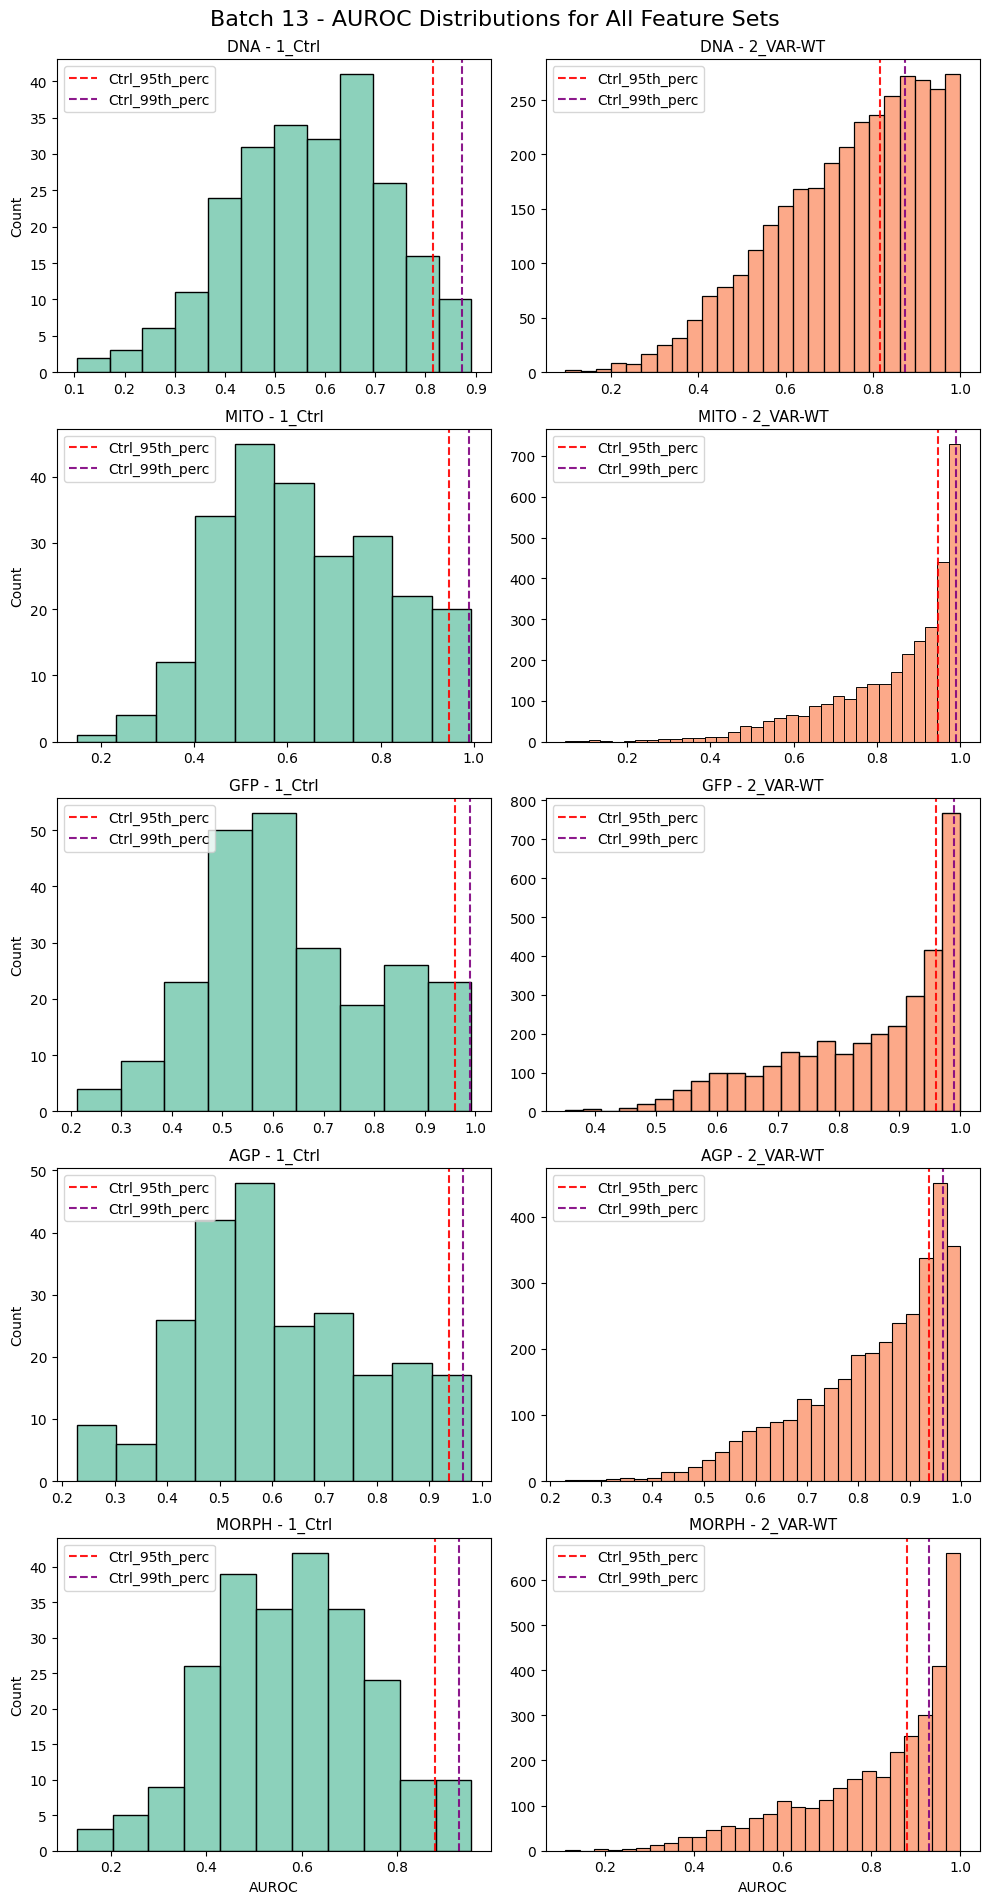

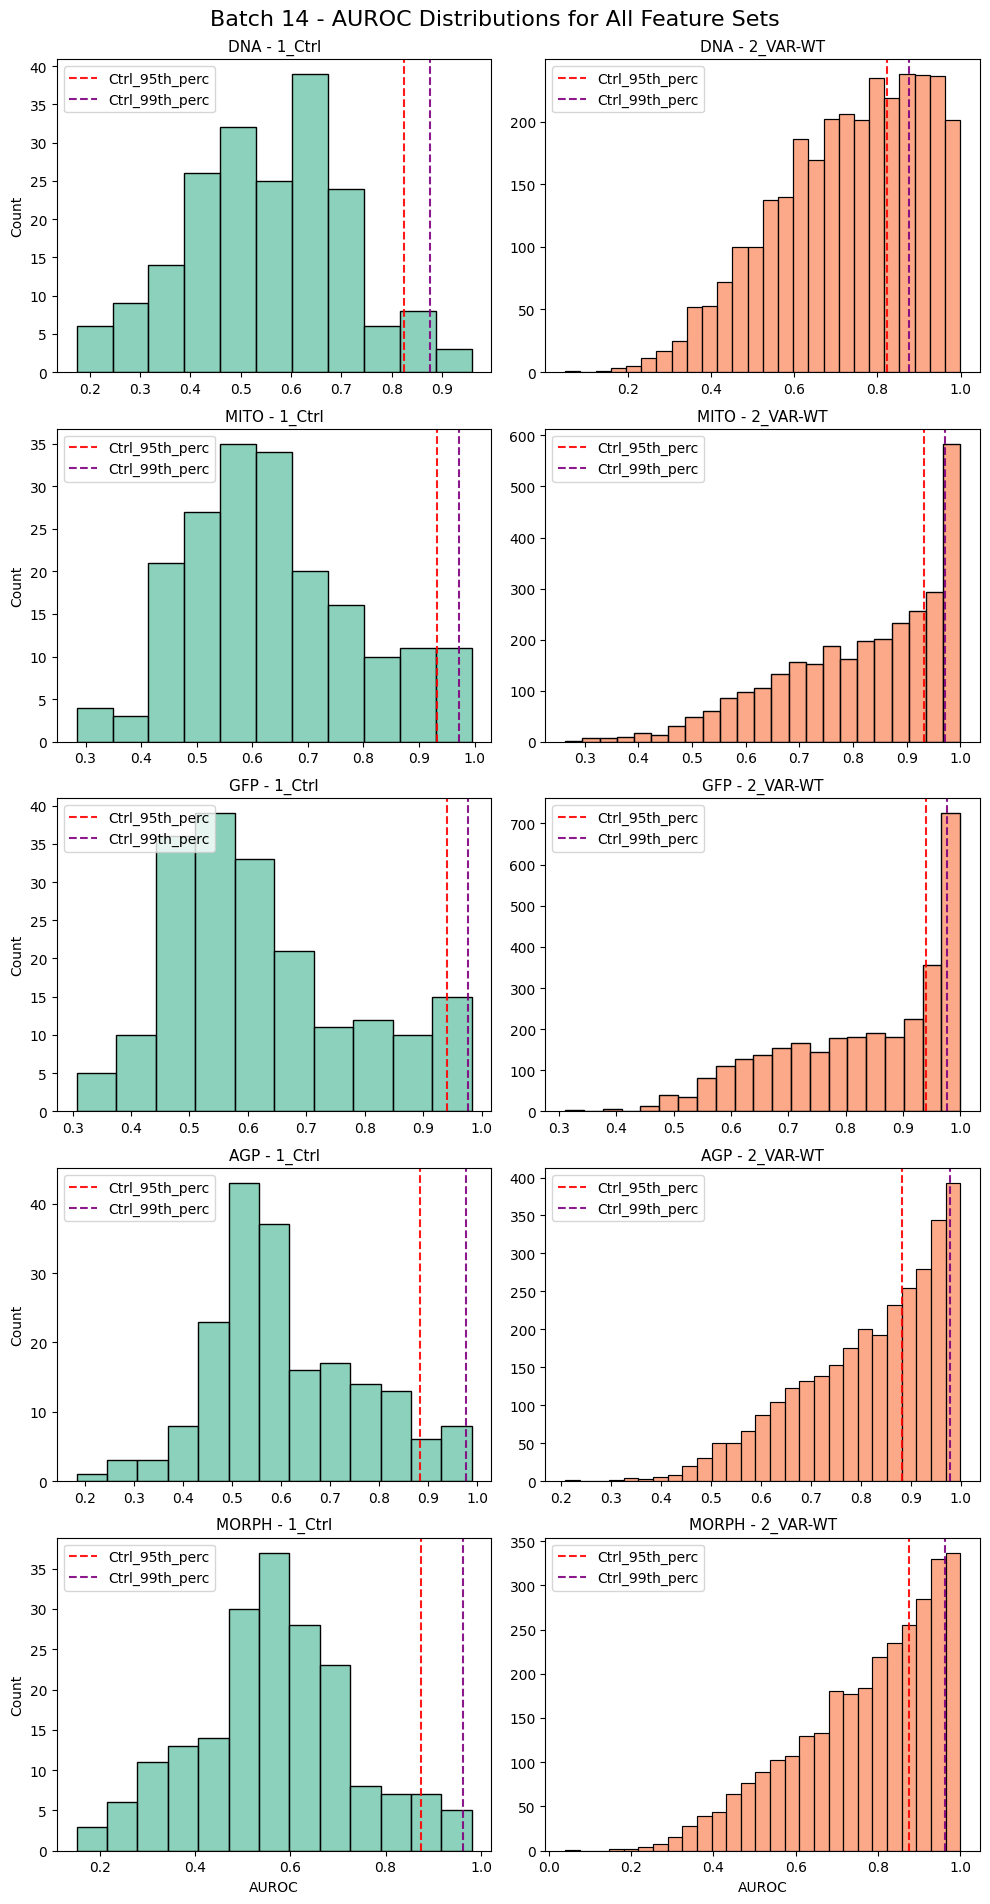

In [9]:
# Get dimensions for subplot grid
n_changes = len(FEAT_SETS)
n_node_types = len(sorted(metrics_df['Node_Type'].unique()))
node_types_sorted = sorted(metrics_df['Node_Type'].unique())

for batch_id in BIO_REP_BATCHES:
    batch_num = batch_id.split("_")[-1]
    # Create figure with subplots for this batch
    fig, axes = plt.subplots(
        n_changes, n_node_types, 
        figsize=(5 * n_node_types, 4 * n_changes),
        squeeze=False
    )
    for change_idx, change in enumerate(FEAT_SETS):
        ## Only need to plot for one change, since the other is duplicative
        # if change == "GFP":
        #     df_local = metric_df_dict[f"B{batch_num}_met_thres"].filter(pl.col("Classifier_type") == change)
        #     plot_metric_dist(df_local, value="Training_imbalance", batch=batch_num, col="Node_Type")
        #     plot_metric_dist(df_local, value="trainsize_0", batch=batch_num, col="Node_Type")
        #     plot_metric_dist(df_local, value="trainsize_1", batch=batch_num, col="Node_Type")
        perc_dict = dict([(
            f"{auroc_thres*100:.0f}th_perc", metric_df_dict[f"B{batch_num}_met_thres"].filter(pl.col("Classifier_type") == change).select(f"AUROC_thresh_{auroc_thres*100:.0f}").mean().to_numpy()[0][0]
        ) for auroc_thres in AUROC_THRESHOLDS])

        # Get filtered data for this batch and change
        plot_data = metric_df_dict[f"B{batch_num}_met_thres"].filter(
            (pl.col("Classifier_type") == change) & 
            (pl.col("Training_imbalance") < TRN_IMBAL_THRES)
        ).to_pandas()
        
        # Create subplot for each node type
        for node_idx, node_type in enumerate(node_types_sorted):
            ax = axes[change_idx, node_idx]
            
            # Filter data for this node type
            node_data = plot_data[plot_data['Node_Type'] == node_type]
            
            if not node_data.empty:
                # Create histogram
                sns.histplot(
                    data=node_data,
                    x="AUROC",
                    kde=False,
                    ax=ax,
                    color=sns.color_palette("Set2")[node_idx % len(sns.color_palette("Set2"))]
                )                
                # Add vertical lines for thresholds
                colors = ['red', 'purple', 'orange', 'brown']  # Different colors for different thresholds
                for i, (label, auroc_val) in enumerate(perc_dict.items()):
                    color = colors[i % len(colors)]
                    ax.axvline(auroc_val, color=color, linestyle='--', alpha=0.9, label=f"Ctrl_{label}")
                ax.legend(loc="upper left")
                # Set title and labels
                ax.set_title(f"{change.upper()} - {node_type}", fontsize=11)
                # Add legend only to the first subplot
                # if change_idx == 0 and node_idx == 0:
                #     ax.legend(loc='upper right', fontsize=8)
            else:
                ax.set_title(f"{change.capitalize()} - {node_type} (No Data)", fontsize=11)
                ax.axis('off')
            
            # Set labels
            if change_idx == n_changes - 1:  # Bottom row
                ax.set_xlabel("AUROC")
            else:
                ax.set_xlabel("")
                
            if node_idx == 0:  # Left column
                ax.set_ylabel("Count")
            else:
                ax.set_ylabel("")
    
    # Add overall title for the batch
    fig.suptitle(f"Batch {batch_num} - AUROC Distributions for All Feature Sets", 
                 fontsize=16, y=0.95)
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=.925)
    
    fig.savefig(
        os.path.join(OUTPUT_DIR, f"B{batch_num}_ctrl_var-wt_dist.png"),
        dpi=300,
        bbox_inches="tight"
    )

## 3. Correlation between biological replicates

Spearman's correlation: 0.6018568629447246
Spearman's correlation: 0.5799551587005956
Spearman's correlation: 0.7847684011795617
Spearman's correlation: 0.7477104862655782
Spearman's correlation: 0.5612475120668108


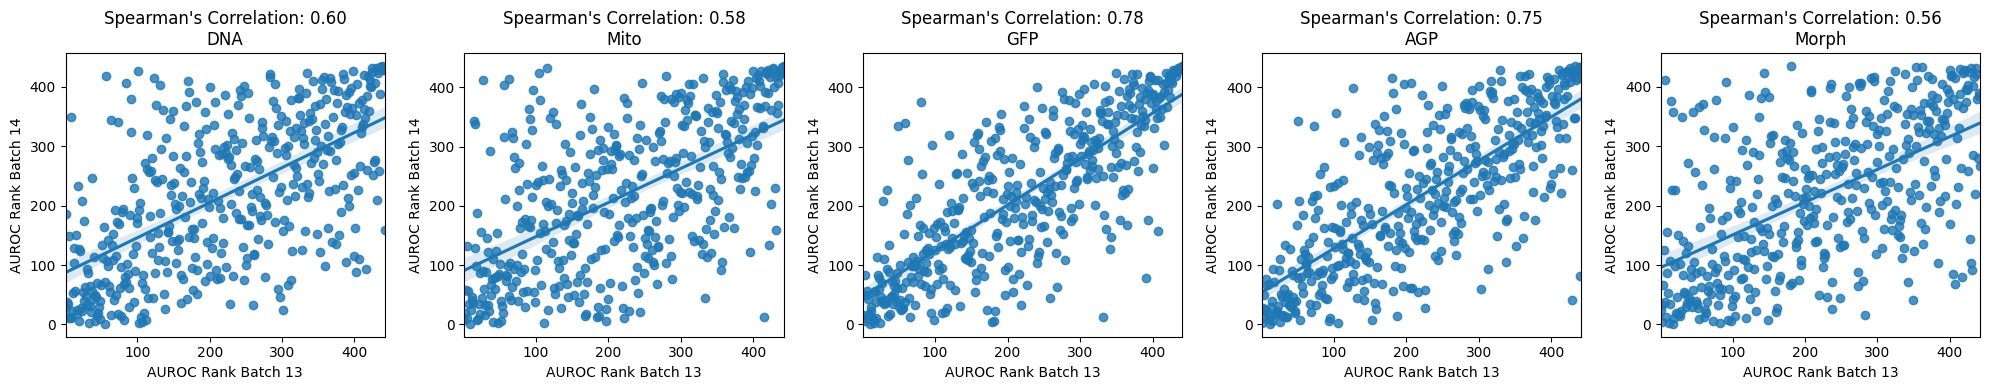

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

fig, axes = plt.subplots(1, 5, figsize=(20,4))
for classifier_type in FEAT_SETS:
    # Select the columns "allele_0" and "AUROC_rank" from both dataframes
    set1_ranks = metric_df_dict["B13_allele_summary"].filter(
        (pl.col("Classifier_type") == classifier_type)
    ).with_columns(
        pl.col('AUROC_mean').rank('dense').alias('AUROC_rank')
    ).select(["allele_0", "AUROC_rank"])
    set2_ranks = metric_df_dict["B14_allele_summary"].filter(
        (pl.col("Classifier_type") == classifier_type)
    ).with_columns(
        pl.col('AUROC_mean').rank('dense').alias('AUROC_rank')
    ).select(["allele_0", "AUROC_rank"])

    # print(classifier_type, set1_ranks, set1_ranks)
    # Join the dataframes on the "allele_0" column
    joined_ranks = set1_ranks.join(set2_ranks, on="allele_0", how="inner", suffix="_batch14")
    # print(joined_ranks.sort(by="allele_0"))
    # Calculate the Spearman's correlation between the ranks
    spearman_corr, _ = spearmanr(joined_ranks["AUROC_rank"], joined_ranks["AUROC_rank_batch14"])
    print(f"Spearman's correlation: {spearman_corr}")

    # bio_rep1_thres = metric_df_dict["B13_allele_summary"].filter(
    #     (pl.col("Classifier_type") == classifier_type)
    # )['AUROC_thresh'].unique()[0]
    # bio_rep2_thres = metric_df_dict["B14_allele_summary"].filter(
    #     (pl.col("Classifier_type") == classifier_type)
    # )['AUROC_thresh'].unique()[0]
    
    # Plot the correlation using a regression plot
    sns.regplot(x="AUROC_rank", y="AUROC_rank_batch14", data=joined_ranks.to_pandas(), ax=axes[FEAT_SETS.index(classifier_type)])
    # axes[FEAT_SETS.index(classifier_type)].axvline(bio_rep1_thres, linestyle="dashed", color="tomato")
    # axes[FEAT_SETS.index(classifier_type)].axhline(bio_rep2_thres, linestyle="dashed", color="tomato")
    axes[FEAT_SETS.index(classifier_type)].set_title(f"Spearman's Correlation: {spearman_corr:.2f}\n{classifier_type}")
    axes[FEAT_SETS.index(classifier_type)].set_xlabel(f"AUROC Rank Batch {BIO_REP_BATCHES[0].split('_')[-1]}")
    axes[FEAT_SETS.index(classifier_type)].set_ylabel(f"AUROC Rank Batch {BIO_REP_BATCHES[1].split('_')[-1]}")

plt.tight_layout()
plt.subplots_adjust(wspace=.25)
plt.savefig(
    os.path.join(OUTPUT_DIR, f"AUROC_rank_correlation.png"),
    dpi=300,
    bbox_inches="tight"
)

In [11]:
# set1 = metric_sum_df_dict["2025_01_27_Batch_13"].filter((pl.col("Classifier_type") == "localization")&(pl.col("AUROC_mean") >= pl.col("AUROC_thresh"))).select(pl.col("allele_0"))
# set2 = metric_sum_df_dict["2025_01_28_Batch_14"].filter((pl.col("Classifier_type") == "localization")&(pl.col("AUROC_mean") >= pl.col("AUROC_thresh"))).select(pl.col("allele_0"))

In [12]:
# metrics_df.filter(pl.col("Plate")=="2025-03-17_B15A1A2_P1T1").unique(subset="well_0")#.with_columns(pl.col("well_0").alias("well_po"))#.agg(pl.mean)
# categorical mode (exactly your original behavior):

# for platemap in os.listdir(platemap_dir):
#     platemap_df = pl.read_csv(os.path.join(platemap_dir, platemap), separator="\t")
#     # display(platemap_df)
#     for key, df in metric_df_dict.items():
#         # print(key)
#         if "met_thres" in key:
#             for plate in df["Plate"].unique():
#                 print(plate)
#                 auroc_platemap = platemap_df.with_columns(
#                         pl.concat_str([pl.col("well_position"), pl.col("gene_allele")], separator="_").alias("well_allele")
#                 ).join(
#                     df.filter((pl.col("Plate")==plate)&(pl.col("Metadata_Control"))).unique(subset="well_0").with_columns(
#                         pl.concat_str([pl.col("well_0"), pl.col("allele_0")], separator="_").alias("well_allele")
#                     ),
#                     left_on="well_allele", right_on="well_allele", how="left"
#                 ).filter(pl.col("AUROC").is_not_null())
#                 # display(auroc_platemap)
#                 plot_platemap(
#                     auroc_platemap,
#                     plate_name=plate,
#                     well_pos_col="well_position",
#                     value_col="AUROC",
#                     label_cols=("gene_allele","AUROC"),
#                     value_type="continuous",
#                     continuous_cmap="viridis_r"
#                 )

In [13]:
# metrics_df.filter(pl.col("Plate")=="2025-03-17_B15A1A2_P1T1").unique(subset="well_0")#.with_columns(pl.col("well_0").alias("well_po"))#.agg(pl.mean)
# categorical mode (exactly your original behavior):

# for platemap in os.listdir(platemap_dir):
#     platemap_df = pl.read_csv(os.path.join(platemap_dir, platemap), separator="\t")
#     for key, df in metric_df_dict.items():
#         if "met_thres" in key:
#             for change in CELL_CHANGES:
#                 df_chg = df.filter(pl.col("Classifier_type") == change)
#                 for plate in df_chg["Plate"].unique():
#                     # print(plate)
#                     auroc_platemap = platemap_df.with_columns(
#                             pl.concat_str([pl.col("well_position"), pl.col("gene_allele")], separator="_").alias("well_allele")
#                     ).join(
#                         df_chg.filter((pl.col("Plate")==plate)&(~pl.col("Metadata_Control"))).unique(subset="well_0").with_columns(
#                             pl.concat_str([pl.col("well_0"), pl.col("allele_0")], separator="_").alias("well_allele")
#                         ),
#                         left_on="well_allele", right_on="well_allele", how="left"
#                     ).filter(pl.col("AUROC").is_not_null())
#                     # display(auroc_platemap)
#                     plot_platemap(
#                         auroc_platemap,
#                         plate_name=f"{plate}_{change}",
#                         well_pos_col="well_position",
#                         value_col="AUROC",
#                         label_cols=("gene_allele","AUROC"),
#                         value_type="continuous",
#                         continuous_cmap="viridis_r"
#                     )

## 4. Calling hits

In [14]:
import glob
from functools import reduce
import operator

metric_sum_df_dict = {}
for met_sum_file in glob.glob(f"{OUTPUT_DIR}/B*/*.csv"):
    metric_sum_df_dict[met_sum_file.split('/')[-2]] = pl.read_csv(met_sum_file)

metrics_sum_wtvar = pl.concat(list(metric_sum_df_dict.values()))
metrics_sum_wtvar

# split into morphology and localization, and count the proportion of classifiers that surpass the 0.99 NULL F1 score
# morph_wtvar = metrics_sum_wtvar.filter(pl.col("Classifier_type") == "Morph")
# local_wtvar = metrics_sum_wtvar.filter(pl.col("Classifier_type") == "GFP")
# print(local_wtvar.shape)
# print(morph_wtvar.shape)

Classifier_type,allele_0,Allele_set,Batch,AUROC_thresh_95,AUROC_thresh_99,AUROC_mean,AUROC_zscore_mean,trainsize_0_mean,testsize_0_mean,trainsize_1_mean,testsize_1_mean,Training_imbalance_mean
str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Morph""","""BAP1_Thr423Lys""","""A7A8P1_""","""B13""",0.879019,0.930661,0.536632,-0.238554,1104.0,368.0,1183.5,394.5,1.097819
"""Morph""","""CCM2_Gly214Cys""","""A7A8P2_""","""B13""",0.879019,0.930661,0.837549,1.532178,1302.75,434.25,1205.5,401.833333,1.50328
"""DNA""","""FARS2_Thr246Met""","""A7A8P1_""","""B13""",0.815251,0.873573,0.614638,0.26845,632.142857,214.857143,681.857143,220.0,1.903492
"""Mito""","""RAD51D_Met308Val""","""A7A8P2_""","""B13""",0.946098,0.989408,0.97468,1.881443,1121.25,373.75,1200.75,400.25,1.086046
"""GFP""","""BRAF_Val471Phe""","""A7A8P1_""","""B13""",0.960127,0.989189,0.899664,1.46045,1597.5,532.5,1319.25,439.75,1.254955
…,…,…,…,…,…,…,…,…,…,…,…,…
"""Mito""","""F9_Pro197Ser""","""A7A8P1_""","""B14""",0.933201,0.972267,0.741698,0.669231,593.25,197.75,870.75,290.25,1.480481
"""Morph""","""F9_Arg75Gln""","""A7A8P1_""","""B14""",0.874311,0.962542,0.606106,0.190999,736.5,245.5,870.75,290.25,1.201444
"""Mito""","""FARS2_His135Asp""","""A7A8P1_""","""B14""",0.933201,0.972267,0.66867,0.199232,690.0,230.0,531.375,177.125,1.442754


In [15]:
def plot_gene_level_summary(total_allele_hit_sum_df, cell_change, auroc_thres):
    # 1. Fill nulls with 0
    total_allele_hit_sum_df["len_hits"] = total_allele_hit_sum_df["len_hits"].fillna(0).astype(int)
    # 2. Compute percentage of hits
    total_allele_hit_sum_df["pct_hits"] = total_allele_hit_sum_df["len_hits"] / total_allele_hit_sum_df["len"] * 100
    # 3. Sort by percentage descending
    total_allele_hit_sum_df = total_allele_hit_sum_df.sort_values(by=["len","pct_hits"], ascending=True).reset_index(drop=True)
    
    y = range(len(total_allele_hit_sum_df))
    n_genes = len(y)

    # 4. Dynamically scale figure size
    bar_width = 0.4
    fig_height = max(6, min(n_genes * 0.3, 25))  # cap size for huge plots
    fig_width = 8
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    # Plot bars
    ax.barh(y, total_allele_hit_sum_df["len"], color="skyblue", label="# Variants")
    ax.barh(y, total_allele_hit_sum_df["len_hits"], color="tomato", label="# of Hits")

    # Annotate percentage
    for i, pct in enumerate(total_allele_hit_sum_df["pct_hits"]):
        ax.text(
            total_allele_hit_sum_df.loc[i, "len"] + 0.5,
            i,
            f"{pct:.1f}%",
            ha="left",
            va="center",
            fontsize=10 if n_genes > 20 else 11,
            rotation=0,
        )
    # Axis formatting
    ax.set_yticks(y)
    ax.set_yticklabels(
        total_allele_hit_sum_df["by"],
        fontsize=10 if n_genes > 20 else 11,
    )
    ax.set_xlabel("Count", fontsize=11)
    ax.set_title(
        f"Altered {cell_change.capitalize()} Hits per Gene (AUROC thres: {auroc_thres})",
        fontsize=13,
    )
    ax.set_xlim(0, total_allele_hit_sum_df["len"].max() * 1.1)
    ax.set_ylim(-1, len(y) + .3)
    ax.legend(fontsize=11, loc="lower right")
    # Improve spacing
    plt.tight_layout()
    plt.show()

    return total_allele_hit_sum_df

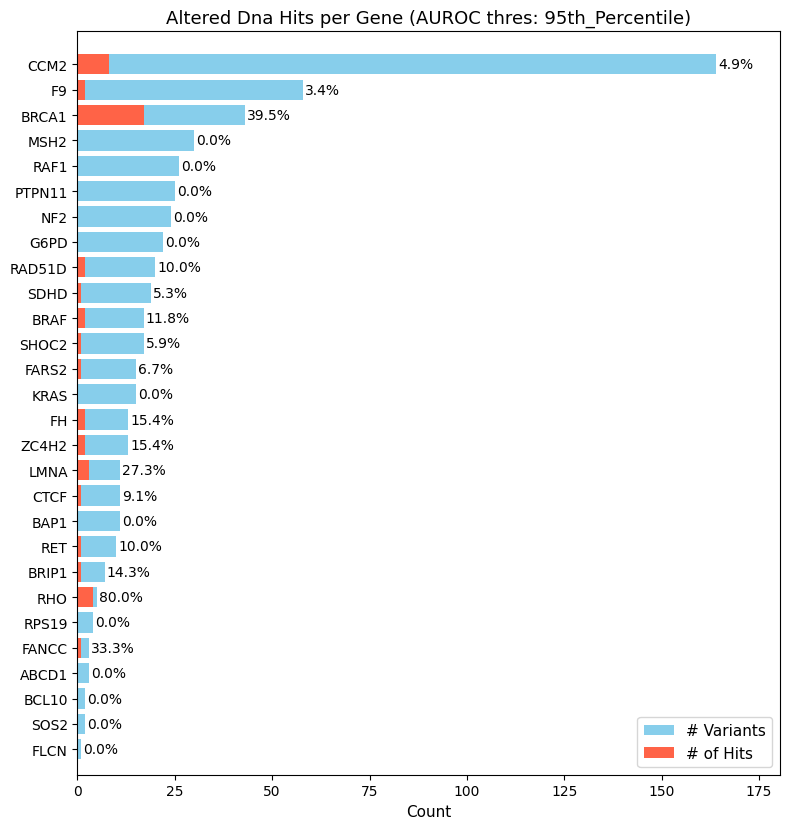

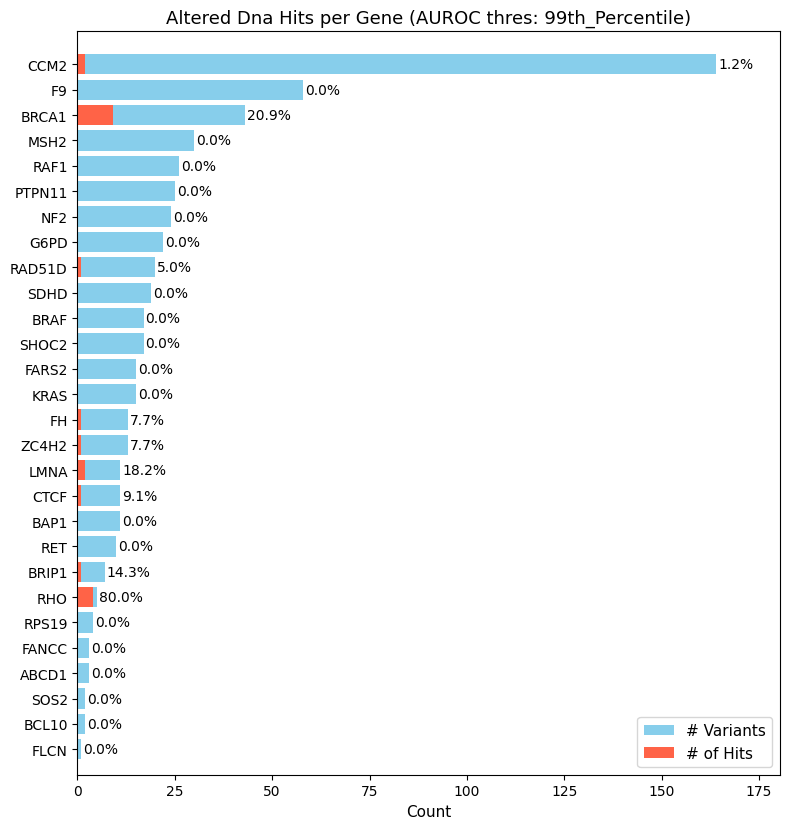

AUROC summary output at: ../../../3_outputs/1_snakemake_pipeline/3.smp_results_analyses/3.classification_analyses/2025_01_Batch_13-14/altered_DNA_summary_auroc.csv


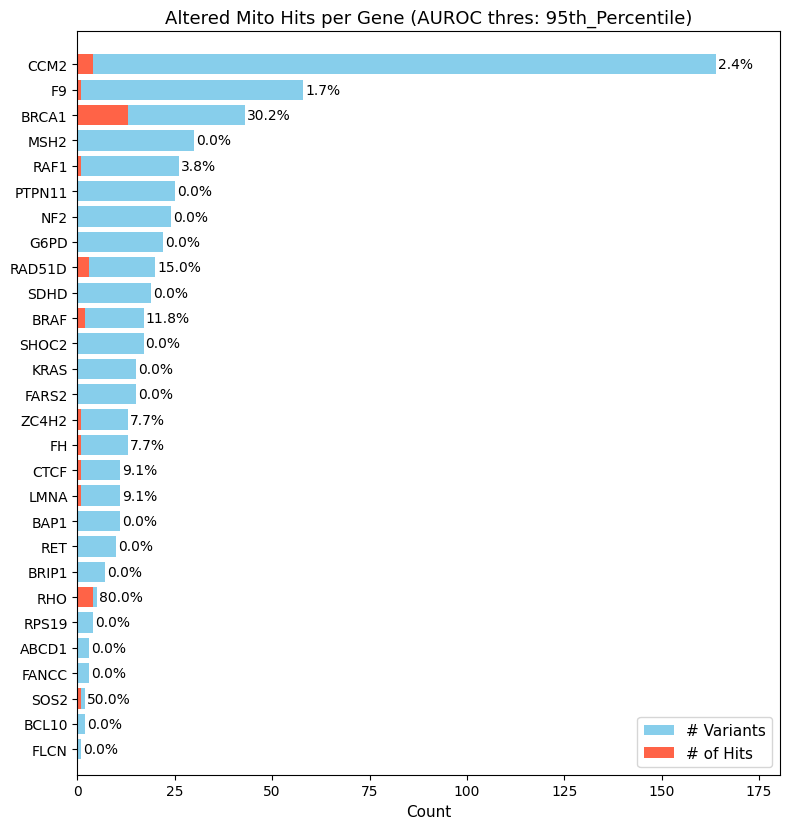

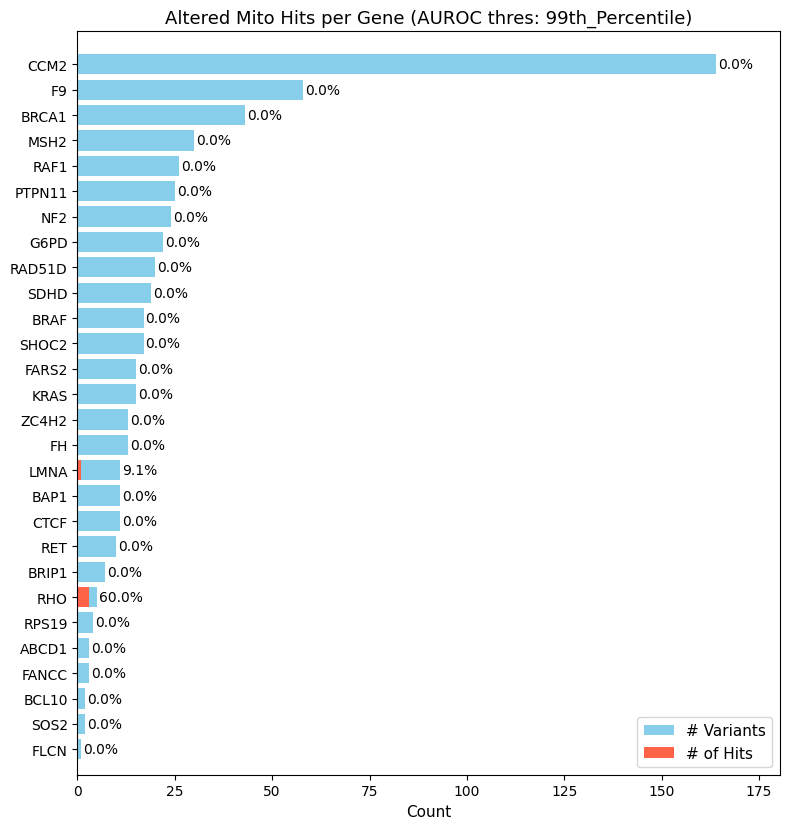

AUROC summary output at: ../../../3_outputs/1_snakemake_pipeline/3.smp_results_analyses/3.classification_analyses/2025_01_Batch_13-14/altered_Mito_summary_auroc.csv


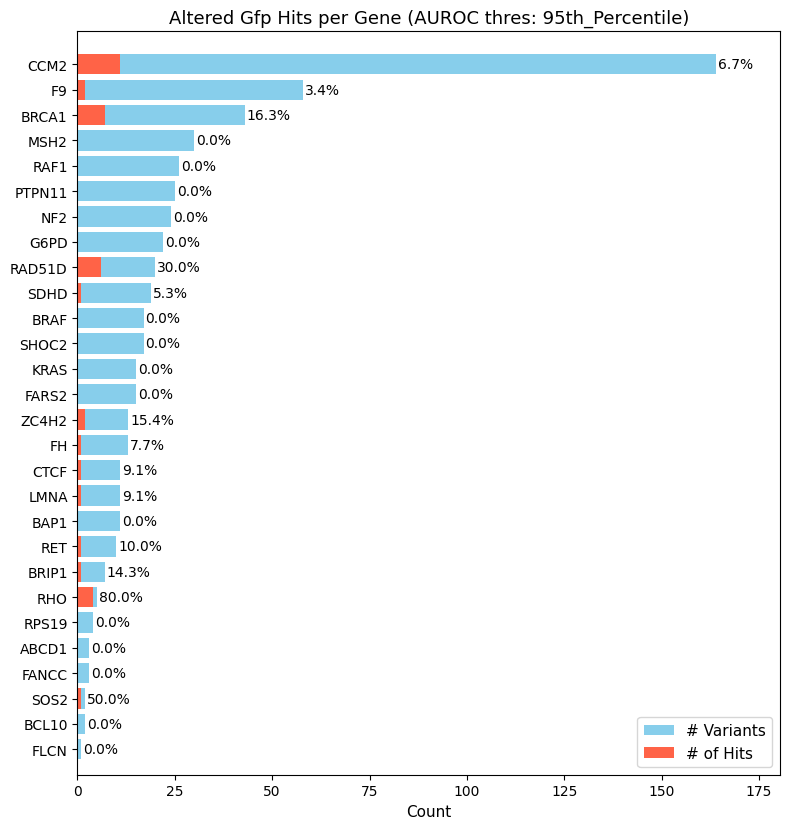

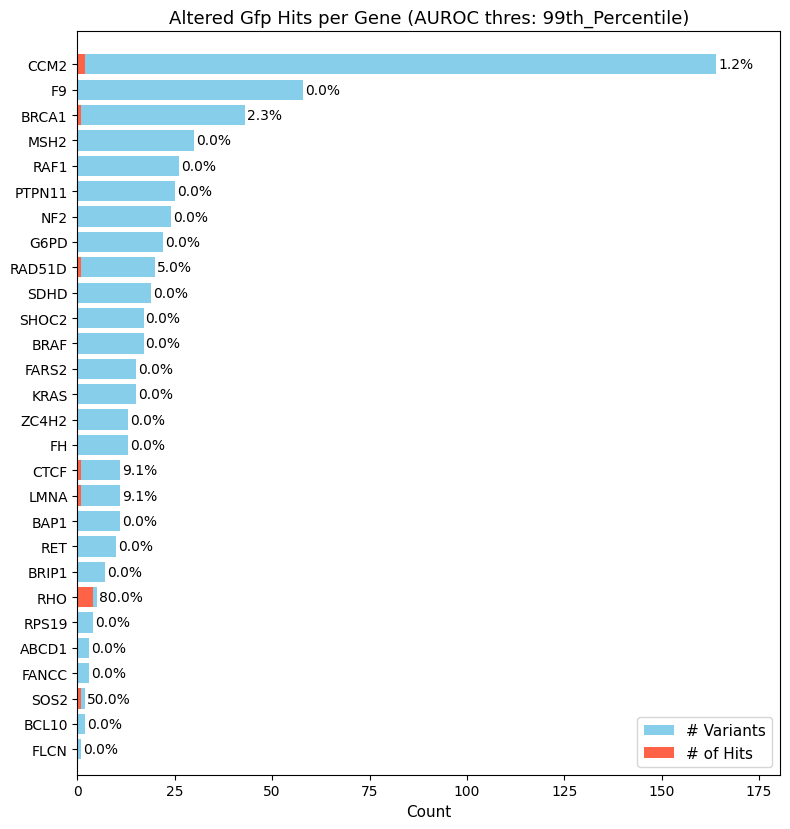

AUROC summary output at: ../../../3_outputs/1_snakemake_pipeline/3.smp_results_analyses/3.classification_analyses/2025_01_Batch_13-14/altered_GFP_summary_auroc.csv


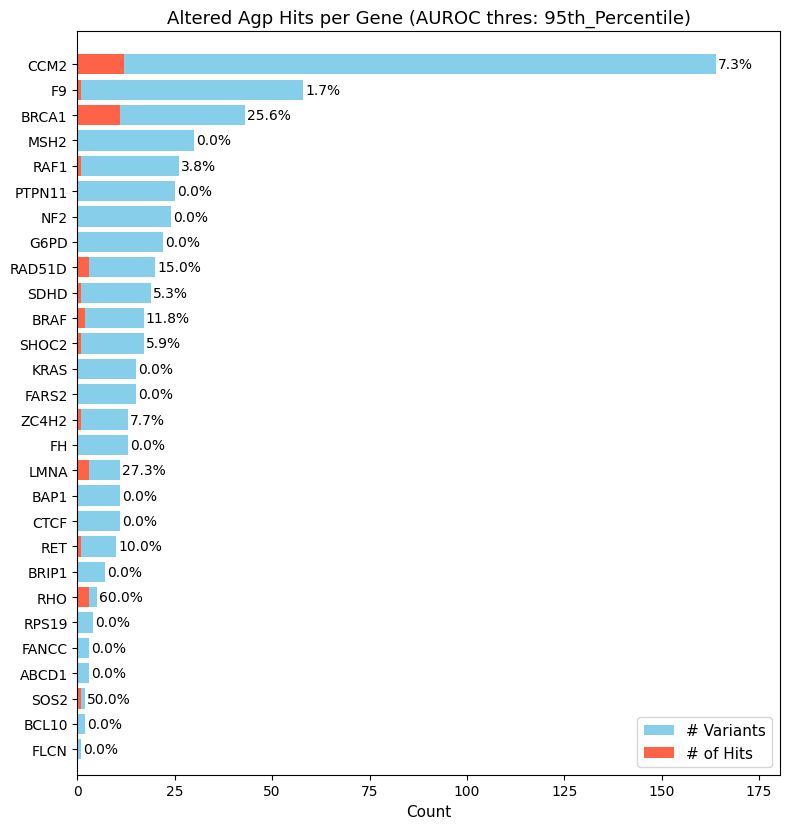

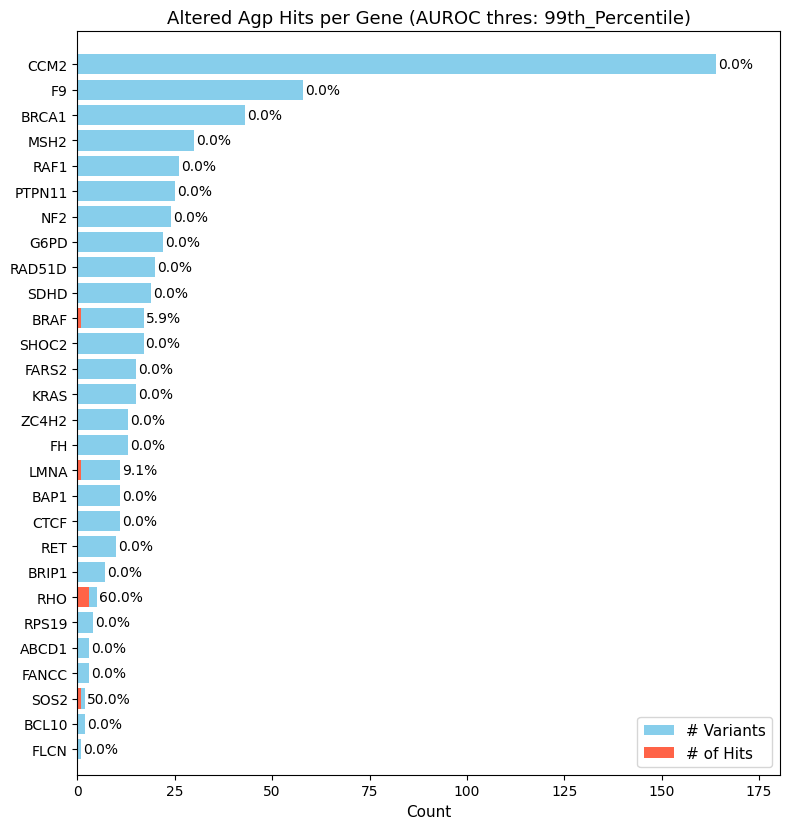

AUROC summary output at: ../../../3_outputs/1_snakemake_pipeline/3.smp_results_analyses/3.classification_analyses/2025_01_Batch_13-14/altered_AGP_summary_auroc.csv


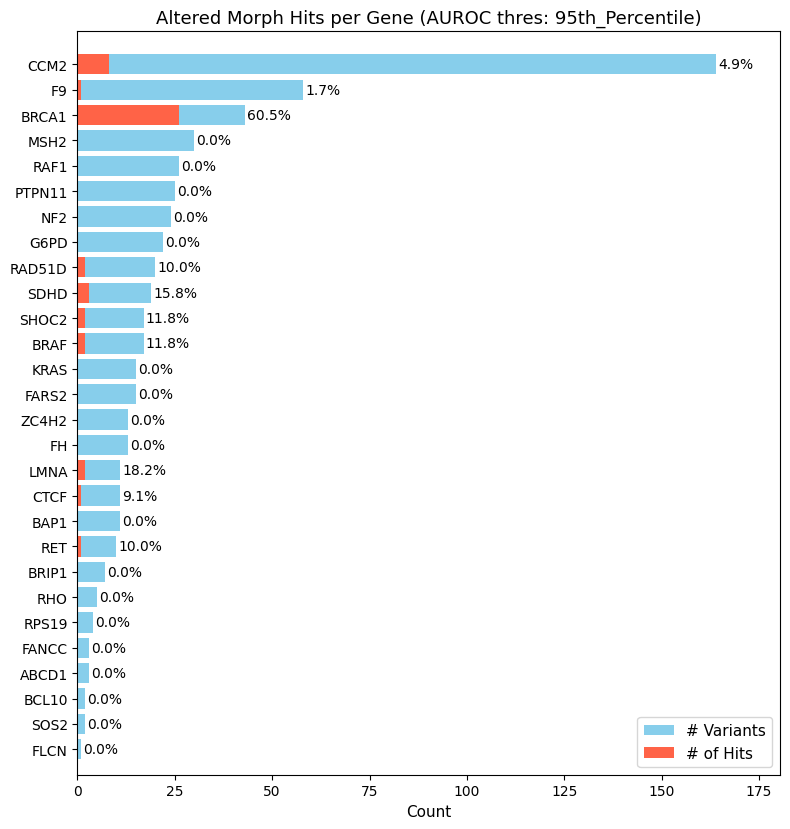

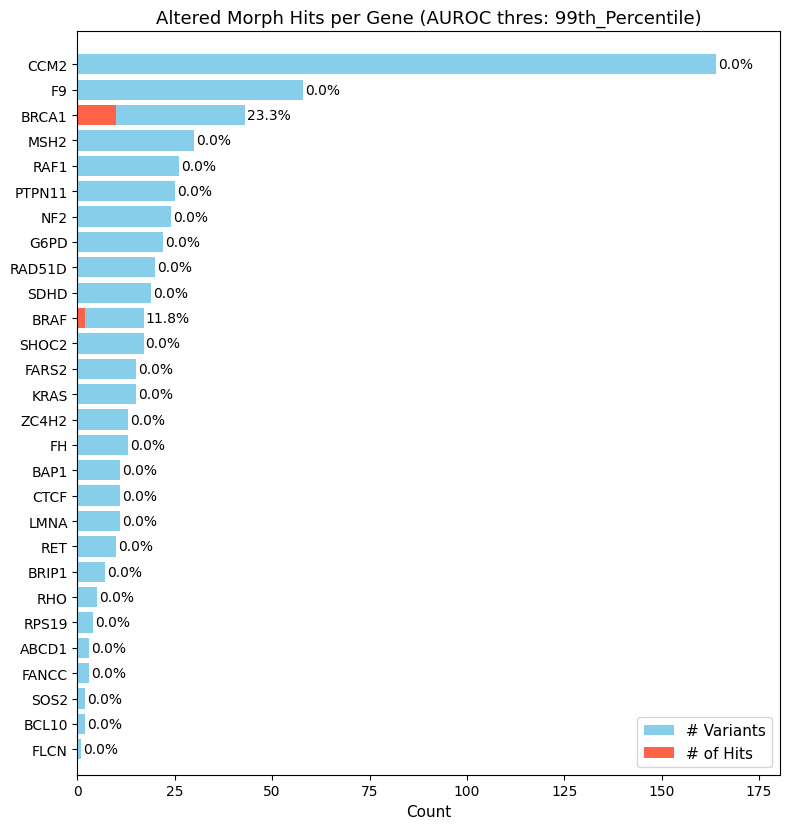

AUROC summary output at: ../../../3_outputs/1_snakemake_pipeline/3.smp_results_analyses/3.classification_analyses/2025_01_Batch_13-14/altered_Morph_summary_auroc.csv


In [16]:
for cell_change in FEAT_SETS:
    ## Filter the change to detect
    cell_chg_wtvar = metrics_sum_wtvar.filter(pl.col("Classifier_type") == cell_change)
    ## Per each batch, get the hits
    cell_chg_wtvar = cell_chg_wtvar.with_columns([
        pl.when(pl.col("AUROC_mean") > pl.col(f"AUROC_thresh_{auroc*100:.0f}"))
        .then(1)
        .otherwise(0)
        .alias(f"Altered_{cell_change[:5]}_{auroc*100:.0f}")
        for auroc in AUROC_THRESHOLDS
    ]).unique()

    ## Create separate pivot tables for each threshold and combine them
    all_threshold_dfs = []
    
    for auroc in AUROC_THRESHOLDS:
        threshold_name = f"{auroc*100:.0f}"
        
        # Create pivot for this threshold
        threshold_df = (
            cell_chg_wtvar.pivot(
                index=["allele_0"],
                on="Batch",
                values=f"Altered_{cell_change[:5]}_{threshold_name}",
            )
            # Rename batch columns to include threshold
            .rename({
                f"B{batch.split('_')[-1]}": f"Altered_{cell_change[:5]}_{threshold_name}_batch{batch.split('_')[-1]}" 
                for batch in BIO_REP_BATCHES
            })
            # Add "both batches" column
            .with_columns(
                reduce(
                    operator.and_,
                    [pl.col(f"Altered_{cell_change[:5]}_{threshold_name}_batch{batch.split('_')[-1]}") == 1 
                     for batch in BIO_REP_BATCHES]
                ).alias(f"Altered_{cell_change[:5]}_{threshold_name}_both_batches")
            )
        )
        
        all_threshold_dfs.append(threshold_df)
    
    ## Combine all threshold dataframes using reduce and join
    change_binary = reduce(
        lambda left, right: left.join(right, on="allele_0", how="full", coalesce=True),
        all_threshold_dfs
    )
    
    # Store the result
    # For example: change_binary_dict[cell_change] = change_binary
        
    # ## Per combine the hits from both batches
    # change_binary = (
    #     cell_chg_wtvar.pivot(
    #         index=["allele_0"], ## , "Allele_set"
    #         on="Batch",
    #         values=f"Altered_{cell_change[:5]}",
    #     )
    #     # 1) rename each pivoted batch-column
    #     .rename({f"B{batch.split('_')[-1]}": f"Altered_{cell_change[:5]}_batch{batch.split('_')[-1]}" for batch in BIO_REP_BATCHES})
    #     # 2) add the “both” column by AND-reducing all of them
    #     .with_columns(
    #         reduce(
    #             operator.and_,
    #             [pl.col(f"Altered_{cell_change[:5]}_batch{batch.split('_')[-1]}") == 1 for batch in BIO_REP_BATCHES]
    #         ).alias(f"Altered_{cell_change[:5]}_both_batches")
    #     )
    # )
    
    ## Per combine the AUROC scores from both batches
    change_auroc = cell_chg_wtvar.pivot(
        index=["allele_0"],
        on="Batch",
        values="AUROC_mean",
    ).rename(
        {f"B{batch.split('_')[-1]}": f"AUROC_batch{batch.split('_')[-1]}" for batch in BIO_REP_BATCHES}
    ).with_columns(
        (
            reduce(
                operator.add,
                [
                    pl.col(f"AUROC_batch{batch.split('_')[-1]}")
                    for batch in BIO_REP_BATCHES
                ]
            )
            / len(BIO_REP_BATCHES)
        ).alias("AUROC_Mean")
    )
    change_summary = change_binary.join(change_auroc, on="allele_0")
    # display(change_summary)
    # display(change_summary.filter(pl.col(f"Altered_{cell_change[:5]}_both_batches")))

    for auroc in AUROC_THRESHOLDS:
        threshold_name = f"{auroc*100:.0f}"
        total_allele_hit_sum_df = allele_meta_df.filter(pl.col("node_type")=="allele").unique(subset="gene_allele").group_by(by="symbol").len().sort(by="len", descending=True).join(
            change_summary.filter(pl.col(f"Altered_{cell_change[:5]}_{threshold_name}_both_batches")).with_columns(
            pl.col("allele_0").str.extract(r"^([^_]+)", 1).alias("symbol")
        ).group_by(by="symbol").len().sort(by="len", descending=True), on="by", suffix="_hits", how="left").to_pandas()
        plot_gene_level_summary(total_allele_hit_sum_df, cell_change, f"{threshold_name}th_Percentile")

    if os.path.exists("{OUTPUT_DIR}/altered_{cell_change[:5]}_summary_auroc.csv"):
        print(f"AUROC summary exists at: {OUTPUT_DIR}/altered_{cell_change[:5]}_summary_auroc.csv")
    else:
        print(f"AUROC summary output at: {OUTPUT_DIR}/altered_{cell_change[:5]}_summary_auroc.csv")
        change_summary.write_csv(f"{OUTPUT_DIR}/altered_{cell_change[:5]}_summary_auroc.csv")

In [17]:
change_summary_df = pl.DataFrame()
for cell_change in FEAT_SETS:
    for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
        change_summ = pl.read_csv(f"{OUTPUT_DIR}/altered_{cell_change[:5]}_summary_auroc.csv")
        # display(change_summ.filter(pl.col("allele_0")=="MVK_Ser329Asn"))
        change_summ_auroc_cols = sorted([col for col in change_summ.columns if col.startswith("AUROC_batch")])
        change_summ_altered_cols = sorted([col for col in change_summ.columns if col.endswith("_both_batches")])
        # print(["_".join([col.split("_")[0],col.split("_")[2]+"th_perc"]) for col in change_summ_altered_cols])
        change_summ = change_summ.with_columns(
            [pl.col(col).alias(f"AUROC_BioRep{idx+1}") for idx, col in enumerate(change_summ_auroc_cols)] +
            [pl.col(col).alias("_".join([col.split("_")[0],col.split("_")[2]+"th_perc"])) for idx, col in enumerate(change_summ_altered_cols)]
        ).rename(
            {"allele_0": "gene_allele"}
        ).with_columns(
            pl.lit(cell_change).alias("channel"),
            pl.lit(bio_rep).alias("Metadata_Bio_Batch")
        ).select(pl.col(["gene_allele","AUROC_BioRep1","AUROC_BioRep2","AUROC_Mean",f"Altered_95th_perc",f"Altered_99th_perc","channel","Metadata_Bio_Batch"]))
        change_summary_df = pl.concat([change_summ, change_summary_df], how="diagonal_relaxed")

In [18]:
# change_summary_df.write_csv(f"{OUTPUT_DIR}/altered_summary_auroc.csv")

In [19]:
# 1. Unpivot the value columns from wide to long format
unpivoted = change_summary_df.unpivot(
    index=["gene_allele", "channel", "Metadata_Bio_Batch"],
    on=["AUROC_BioRep1", "AUROC_BioRep2", "AUROC_Mean", "Altered_95th_perc", "Altered_99th_perc"],
    variable_name="variable",
    value_name="value"
)
# 2. Create combined column names with suffixes: e.g. value1_A
unpivoted = unpivoted.with_columns(
    (pl.col("variable") + "_" + pl.col("channel")).alias("var_cat")
)
# 3. Pivot on 'id' with new combined column names
auroc_summary = unpivoted.pivot(
    values="value",
    index=["gene_allele","Metadata_Bio_Batch"],
    on="var_cat",
    aggregate_function="first"
).with_columns(
    pl.col("gene_allele").str.split("_").list.get(0).alias("Gene")
)
auroc_summary.write_csv(f"{OUTPUT_DIR}/imaging_analyses_classification_summary.csv")

In [20]:
auroc_summary.write_csv(f"../../../../../3_integrated_assay_analyses/1_inputs/imaging/imaging_analyses_classification_summary.csv")

## 5. ClinVar

In [22]:
import sys
sys.path.append("../../../..")
from utils import *

In [21]:
clin_var_annot_df = pl.read_csv("../../../../../1_allele_collection/3_outputs/varchamp_clinvar_gnomad.tsv", separator="\t", infer_schema_length=10000)
clin_var_annot_df = clin_var_annot_df.with_columns(
    pl.concat_str([pl.col("symbol"), pl.col("aa_change")], separator="_").alias("allele_0")
)

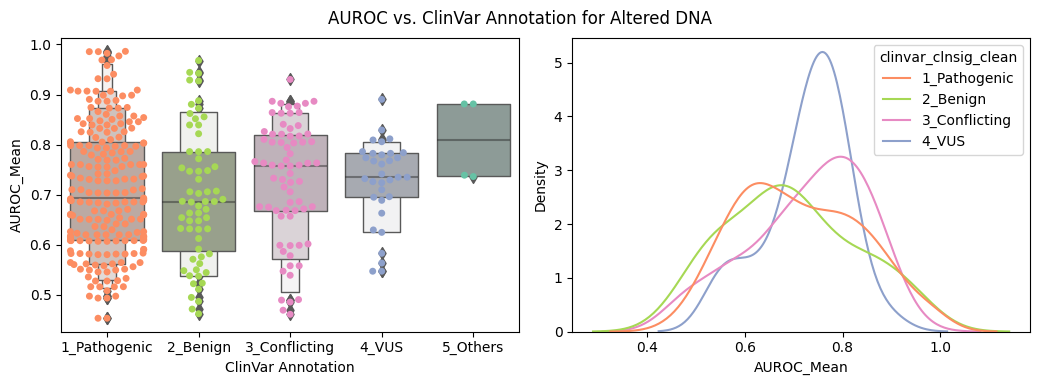

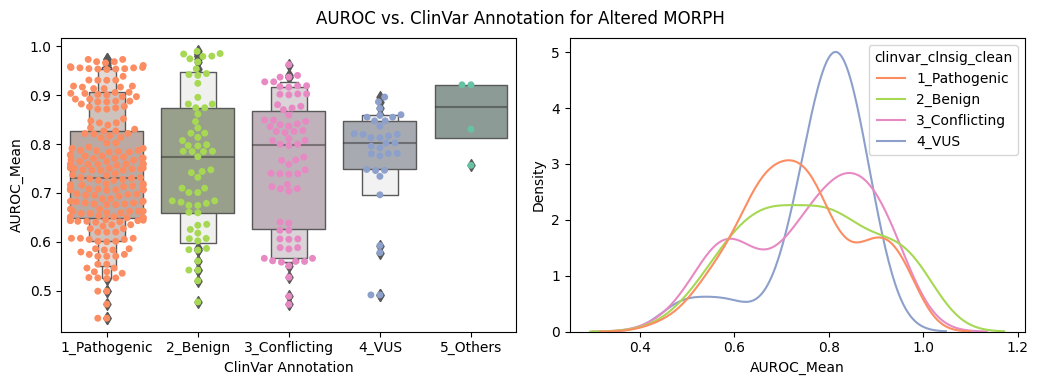

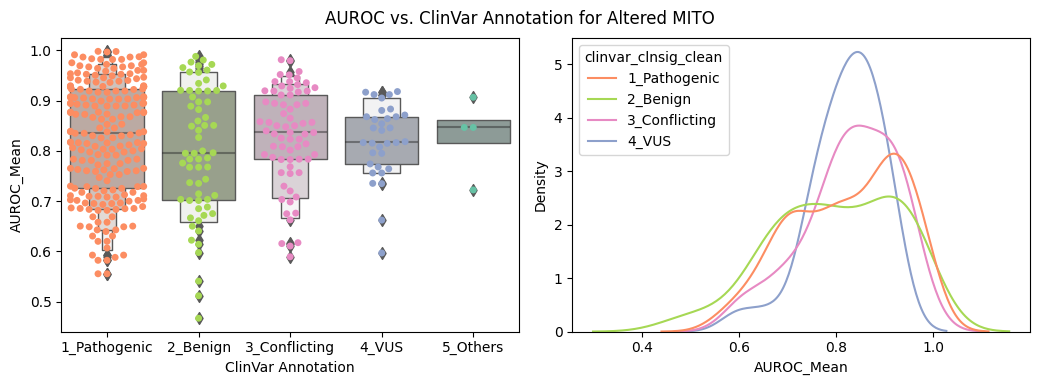

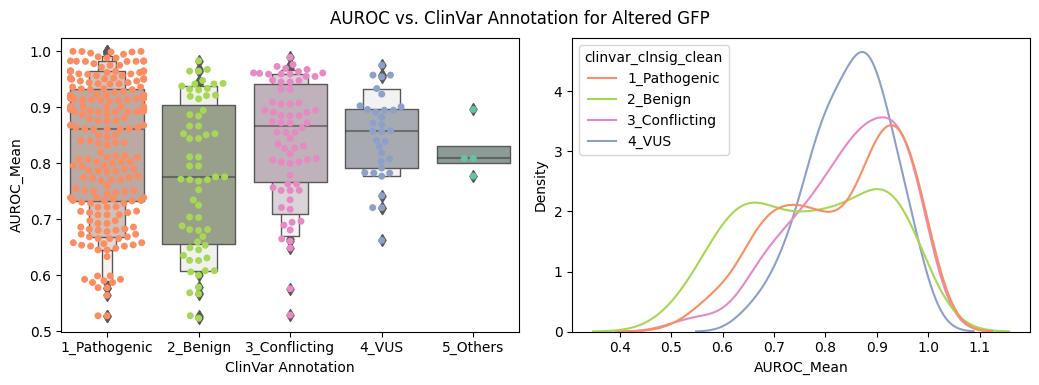

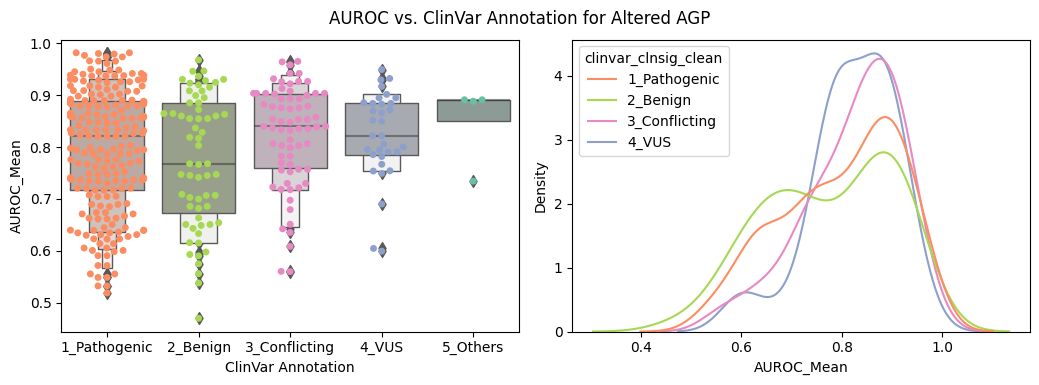

In [25]:
for change_summary in [f for f in os.listdir(OUTPUT_DIR) if f.startswith("altered")]:
    if change_summary == "altered_summary_auroc.csv":
        continue
    change_summary_df = pl.read_csv(os.path.join(OUTPUT_DIR, change_summary))
    fig, ax = plt.subplots(1,2,figsize=(10.5, 4))
    # display(change_summary_df.head())
    summary_clin_var = clin_var_annot_df.join(change_summary_df, on=["allele_0"], how="left")
    sns.boxenplot(data=summary_clin_var.to_pandas(), palette=palette_dict["clinvar_clnsig_clean"],
                  saturation=.15,
                  x="clinvar_clnsig_clean", y="AUROC_Mean", ax=ax[0], 
                  order=sorted(clin_var_annot_df["clinvar_clnsig_clean"].drop_nulls().unique()))
    sns.swarmplot(data=summary_clin_var.to_pandas(), palette=palette_dict["clinvar_clnsig_clean"],
                  x="clinvar_clnsig_clean", y="AUROC_Mean", ax=ax[0], 
                  order=sorted(clin_var_annot_df["clinvar_clnsig_clean"].drop_nulls().unique()))
    ax[0].set_xlabel("ClinVar Annotation")
    fig.suptitle(f"AUROC vs. ClinVar Annotation for Altered {change_summary.split('_')[1].upper()}", y=.95)

    sns.kdeplot(
        data=summary_clin_var.filter(pl.col("clinvar_clnsig_clean")!="5_Others").to_pandas(),
        x="AUROC_Mean",
        common_norm=False,
        ax=ax[1],
        hue="clinvar_clnsig_clean",
        palette=palette_dict["clinvar_clnsig_clean"],
        # col="clinvar_clnsig_clean_dbnsfp",
        # col_order=sorted(summary_clin_var.filter(pl.col("clinvar_clnsig_clean_dbnsfp")!="5_Others")["clinvar_clnsig_clean_dbnsfp"].drop_nulls().unique()),
        hue_order=sorted(summary_clin_var.filter(pl.col("clinvar_clnsig_clean")!="5_Others")["clinvar_clnsig_clean"].drop_nulls().unique())
    )
    plt.tight_layout()